**Performing first trials in jupyter for Tyne and Wear**

**1. Variables declarations**

NB: to be edited depending on who runs this

In [96]:
import pandas as pd
import numpy as np
import geopandas as gpd

msoa_full_file = "./../data/MSOAs_TyneWear_full.csv"
msoa_list_file = "./../data/MSOAs_TyneWear.csv"
lad_list_file = "./../data/LADs_TyneWear.csv"


house_prices_lsoa_xls_file = "./../data/hpssadataset46medianpricepaidforresidentialpropertiesbylsoa.xls"

greenspace_file = "./../data/gis/OS Open Greenspace (GPKG) GB/data/opgrsp_gb.gpkg"

LSOA_boundaries_file = "./../data/gis/LSOA_(Dec_2011)_Boundaries_Super_Generalised_Clipped_(BSC)_EW_V3/"
MSOA_boundaries_file = ""

output_folder = "./../output/"

**2. Variables import**

A. Tables import

In [97]:
msoas_full_df = pd.read_csv(msoa_full_file)
msoas_list_df = pd.read_csv(msoa_list_file)
lad_list_df = pd.read_csv(lad_list_file)

houseprice_excel_tab = pd.read_excel(house_prices_lsoa_xls_file,
                                     sheet_name = "Data") # name of excel tab within the spreadsheet which contains our desired data


some data edits

In [173]:
# editing the dataframe (contains empty rows and other un-necessary stuff inherited from excel)
# a. first 4 rows are empty
# b. 5th row contains the columns names

houseprice_df_notitle = houseprice_excel_tab.iloc[4:] # eliminating first 4 rows
houseprice_df_notitle.columns = houseprice_df_notitle.iloc[0] # attributing columns names from current first row
houseprice_df = houseprice_df_notitle.iloc[1:] # eliminating first row (with names)

# note: think to edit this when reading the file in, already,as in
# https://stackoverflow.com/questions/48036296/using-read-excel-with-converters-for-reading-excel-file-into-pandas-dataframe-re

# checking data type for columns with numerical values
houseprice_df.iloc[:, 0:6].dtypes
# we have a total of 113 columns, checking the last 6 ones
houseprice_df.iloc[:,-6: ].dtypes
# let's eliminate the last 3 columns (empty?)
houseprice_df = houseprice_df.iloc[ : , :-3]
houseprice_df.iloc[:,-6: ].dtypes
# numerical values are read in a type 'object', but we can't change this in the reading command above:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
# in fact 'dtype' option changes it for all the columns
# so we do that only after import, here:

4
Year ending Dec 2020    object
Year ending Mar 2021    object
Year ending Jun 2021    object
Year ending Sep 2021    object
Year ending Dec 2021    object
Year ending Mar 2022    object
dtype: object

In [174]:
colnames_houseprice = houseprice_df.columns.to_list()
numerical_colnames = colnames_houseprice[4:] # selecting only names names of the columns that contain numerical values

In [ ]:
# houseprice_df.head()
# # changing type to numeric for columns from position 4 to end
# # houseprice_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce')
# # houseprice_df.iloc[:,4:].astype(float)
# # houseprice_df.iloc[:,4:] = pd.to_numeric(houseprice_df.iloc[:,4:].stack(),
# #                                          errors='coerce').unstack()
# numerical_cols = houseprice_df.columns.str.startswith('Year ending')
# # object_cols = ~houseprice_df.columns.str.startswith('Year ending')
# houseprice_df.loc[:,houseprice_df.columns.str.startswith('Year ending')]

In [175]:
houseprice_df[numerical_colnames] = houseprice_df[numerical_colnames].apply(pd.to_numeric,
                                                                            errors='coerce')
houseprice_df.iloc[:,-6:].dtypes # worked
# https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns

4
Year ending Dec 2020    float64
Year ending Mar 2021    float64
Year ending Jun 2021    float64
Year ending Sep 2021    float64
Year ending Dec 2021    float64
Year ending Mar 2022    float64
dtype: object

selecting region (case: Tyne and Wear county)

In [179]:
# NOTE: the common field between the houseprice file and regional file is the LAD list
region_LADs_codes_list = lad_list_df["LAD20CD"].to_numpy()

# generating list of LSOAs code for the region
#
# generating list of MSOAs code for the region
#

houseprice_lsoa_region = houseprice_df[houseprice_df["Local authority code"].isin(region_LADs_codes_list)]
houseprice_lsoa_region.dtypes

4
Local authority code     object
Local authority name     object
LSOA code                object
LSOA name                object
Year ending Dec 1995    float64
                         ...   
Year ending Mar 2021    float64
Year ending Jun 2021    float64
Year ending Sep 2021    float64
Year ending Dec 2021    float64
Year ending Mar 2022    float64
Length: 110, dtype: object

In [180]:
# dataframe with LSOAs code and name
lsoas_region_list = houseprice_lsoa_region[["LSOA code", "LSOA name"]]
# creating the list of the region codes for indexing (filtering) purposes
lsoas_region_codes = lsoas_region_list["LSOA code"].to_numpy()

B. Importing geospatial data

In [186]:
# importing greenspace (gpkg)
# note, available layers are: "GreenspaceSite" (green areas) and "AccessPoint" (actual access points)
greenspace = gpd.read_file(greenspace_file,
                           layer = "GreenspaceSite")
greenspace.head() 

,id,function,distinctiveName1,distinctiveName2,distinctiveName3,distinctiveName4,geometry
0,idE56DE736-A177-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((461903.000 1202925.500, 461894..."
1,idE56DE70E-AB4D-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((456682.070 1204040.270, 456711..."
2,idE56DE70E-A916-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((453155.070 1204881.760, 453160..."
3,idE56DE70E-A769-13A9-E053-AAEFA00A0D0E,Religious Grounds,St John's Kirk,None,None,None,"MULTIPOLYGON (((461466.140 1208820.310, 461489..."
4,idE56DE6C9-C6CF-13A9-E053-AAEFA00A0D0E,Play Space,None,None,None,None,"MULTIPOLYGON (((462261.310 1208879.400, 462245..."


<AxesSubplot:>

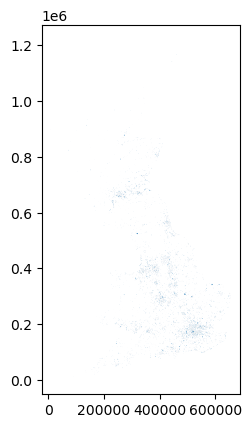

In [187]:
greenspace.plot()

In [188]:
accesspoints_gs = gpd.read_file(greenspace_file,
                           layer = "AccessPoint")
accesspoints_gs.head() 

,id,accessType,refToGreenspaceSite,geometry
0,idB91D85B1-DEE3-47D6-805A-CD6B9ACF4C4F,Pedestrian,idE56DE70E-AB4D-13A9-E053-AAEFA00A0D0E,POINT (456682.070 1204040.270)
1,id4A6E7947-0AFE-48E3-8D42-D4FD1EF4FDEE,Pedestrian,idE56DE70E-A916-13A9-E053-AAEFA00A0D0E,POINT (453155.070 1204881.760)
2,id2614EF8D-E649-4A9F-86F2-95E248B38AFB,Motor Vehicle And Pedestrian,idE56DE70E-A769-13A9-E053-AAEFA00A0D0E,POINT (461466.140 1208820.310)
3,idCC4DDC12-0AE9-4023-A7FE-DE064614A1DC,Pedestrian,idE56DE6C9-C6CF-13A9-E053-AAEFA00A0D0E,POINT (462261.310 1208879.400)
4,idB616B7A5-140F-4564-BDC0-A5AAF61E51AC,Motor Vehicle And Pedestrian,idE56DE70E-A700-13A9-E053-AAEFA00A0D0E,POINT (460892.660 1208953.160)


<AxesSubplot:>

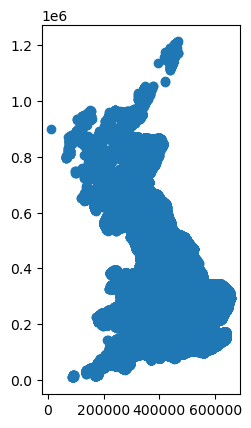

In [189]:
accesspoints_gs.plot()

In [190]:
# importing LSOA admin boundaries (shp or json)
lsoas_shp = gpd.read_file(LSOA_boundaries_file)
lsoas_shp.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((532282.629 181906.496, 532248.250 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((532746.814 181786.892, 532248.250 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((532293.068 182068.422, 532419.592 18..."
3,4,E01000005,City of London 001E,City of London 001E,533581,181265,-0.076280,51.51452,212682.404259,2028.654904,a14c307a-874c-4862-828a-3b1486cc21ea,"POLYGON ((533604.245 181418.129, 533743.689 18..."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.53876,130551.387161,1716.896118,65121a2d-3d2b-4935-9712-690f2993cfd2,"POLYGON ((545271.918 184183.948, 545296.314 18..."


In [191]:
# selecting LSOAs from Tyne and Wear
lsoas_shp_region = lsoas_shp.query('LSOA11CD in @lsoas_region_codes')

<AxesSubplot:>

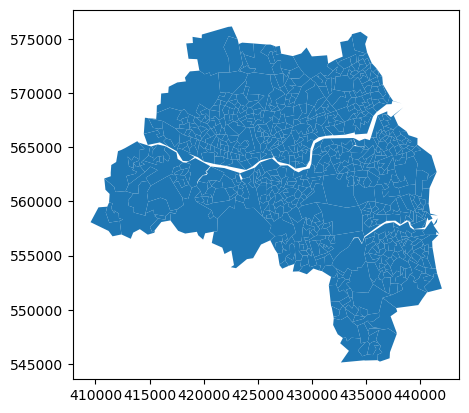

In [192]:
lsoas_shp_region.plot()

**3. Data analysis**

Associating data to geospatial data (or viceversa, adding geography to data)

In [193]:
# searching for common field between the 2 tables
houseprice_lsoa_region.columns

Index(['Local authority code', 'Local authority name', 'LSOA code',
       'LSOA name', 'Year ending Dec 1995', 'Year ending Mar 1996',
       'Year ending Jun 1996', 'Year ending Sep 1996', 'Year ending Dec 1996',
       'Year ending Mar 1997',
       ...
       'Year ending Dec 2019', 'Year ending Mar 2020', 'Year ending Jun 2020',
       'Year ending Sep 2020', 'Year ending Dec 2020', 'Year ending Mar 2021',
       'Year ending Jun 2021', 'Year ending Sep 2021', 'Year ending Dec 2021',
       'Year ending Mar 2022'],
      dtype='object', name=4, length=110)

In [182]:
lsoas_shp_region.columns

Index(['OBJECTID', 'LSOA11CD', 'LSOA11NM', 'LSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Are', 'Shape__Len', 'GlobalID', 'geometry'],
      dtype='object')

In [194]:
# lsoa_gdf_with_houseprice = lsoas_shp_region.merge(houseprice_lsoa_region, 
#                                                   on='')
lsoa_gdf_region_with_houseprice = pd.merge(lsoas_shp_region,
                                 houseprice_lsoa_region,
                                 left_on='LSOA11CD',
                                 right_on="LSOA code")

In [195]:
lsoa_gdf_region_with_houseprice.columns
N=3
lsoa_gdf_region_with_houseprice.iloc[:, 118:124].dtypes # checking type of column
# ... actually price is an 'object' type ... converting it earlier on

Year ending Jun 2021    float64
Year ending Sep 2021    float64
Year ending Dec 2021    float64
Year ending Mar 2022    float64
dtype: object

plotting map... trials

<AxesSubplot:>

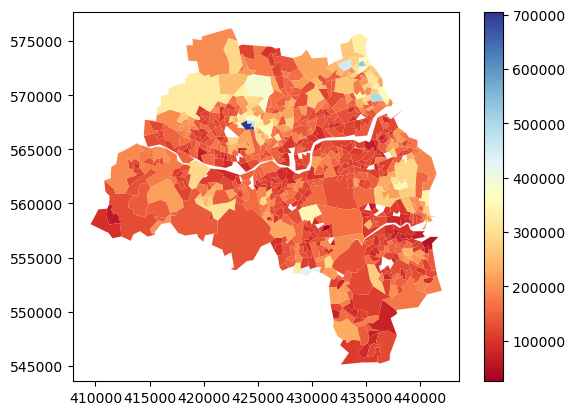

In [203]:
# define legend keys
lgnd_kwds = {'title': 'Median house price per area',
             'loc': 'upper right',
             'bbox_to_anchor': (1.8, 1)}

lsoa_gdf_region_with_houseprice.plot(column="Year ending Mar 2022",
                                     cmap="RdYlBu",
                                     legend=True)

<mark>#TO_DO:</mark> plot also greenspaces and network on top of this